# Predictions on different data quality

## Parameters and model

In [1]:
import sys

sys.path.append('..')
from timeseries.timeseries import StockMarketSeries
from timeseries.utils import SeriesColumn, DeviationScale, DeviationSource
from metrics.utils import MetricLevel
from predictions.prediction import PredictionModel

company_name = "Apple"
path = "../data/timeseries/apple.csv"
time_series_start = 0
time_series_end = 180
column = SeriesColumn.CLOSE
stock = StockMarketSeries(company_name, path, time_series_start, time_series_end)

## Data - one price column

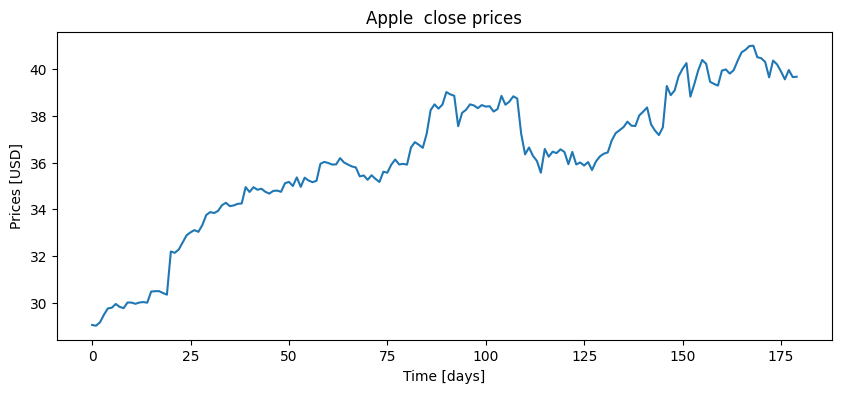

In [2]:
stock.plot_single_series(stock.real_series[column], column)

### Deviated data and its quality

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: courier
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: courier


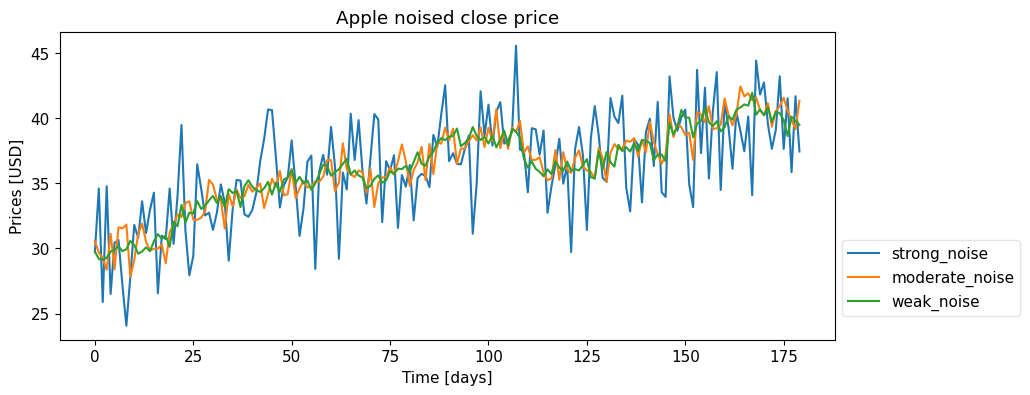

In [3]:
stock.plot_multiple_series("noised close price",
                           strong_noise=stock.all_deviated_series[DeviationSource.NOISE][DeviationScale.HIGHLY][column],
                           moderate_noise=stock.all_deviated_series[DeviationSource.NOISE][DeviationScale.MODERATELY][column],
                           weak_noise=stock.all_deviated_series[DeviationSource.NOISE][DeviationScale.SLIGHTLY][column])

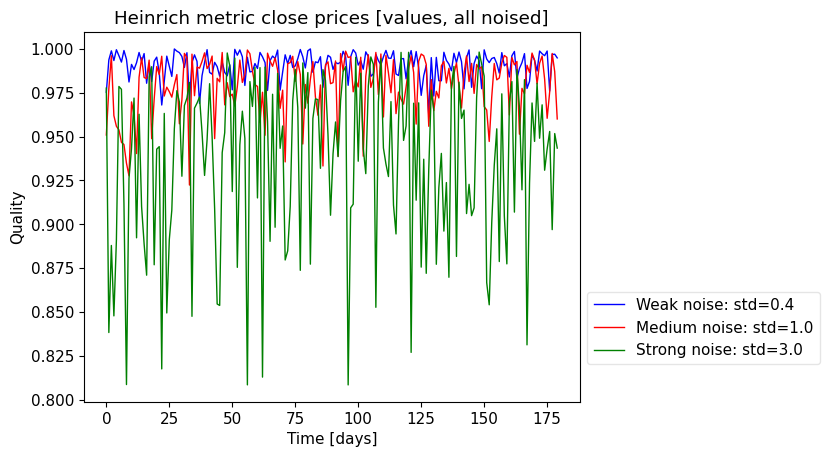

In [4]:
from metrics.correctness import HeinrichCorrectnessMetric

heinrich = HeinrichCorrectnessMetric(stock, alpha={column: 2.1})
qualities = heinrich.values_qualities(column, is_alpha=False)
heinrich.draw_heinrich_qualities(qualities, MetricLevel.VALUES, is_alpha=False, column_name=column)

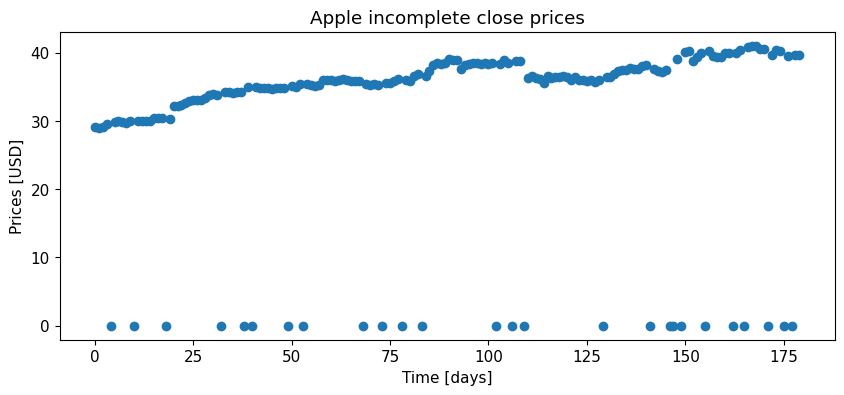

In [5]:
incomplete_data = stock.all_deviated_series[DeviationSource.INCOMPLETENESS][DeviationScale.MODERATELY][column]
stock.plot_single_series(incomplete_data, column, deviation="incomplete", plot_type="o")

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: courier
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: courier


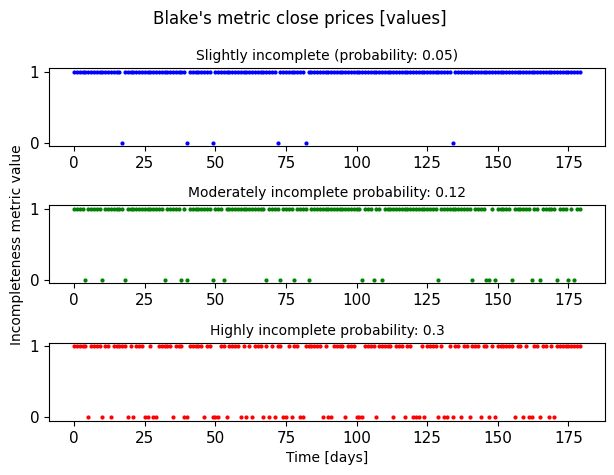

In [6]:
from metrics.completeness import BlakeCompletenessMetric

blake = BlakeCompletenessMetric(stock)
qualities = blake.values_qualities(column)
blake.draw_blake(qualities, MetricLevel.VALUES, column_name=column)

## Predictions parameters

In [7]:
prediction_start = 150
iterations = 3

model = PredictionModel(stock, prediction_start, column, iterations=iterations)

## Statistical methods

In [8]:
from arima import ManualArima

arima_type = ManualArima

## AR(5)

In [9]:
arima = model.configure_model(arima_type, p=5, q=0)

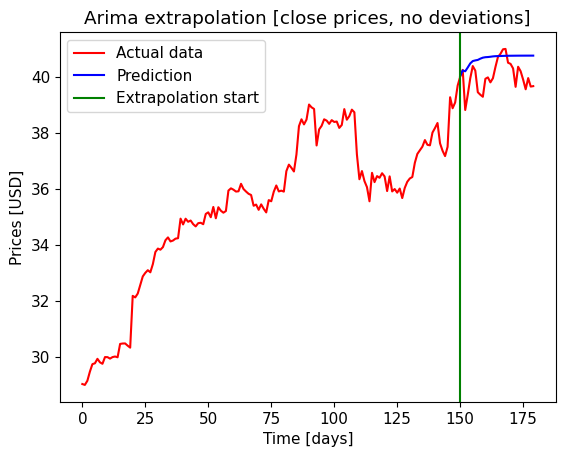

RMS: 0.783 


In [10]:
%%capture --no-stdout --no-display
arima.present_prediction()

In [11]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

Statistics [Apple stock, close price, 3 iterations]

  Deviations source Deviations scale Avg time [ms] Std dev time Avg RMS  \
0              none             none   1259.666667    62.404594   0.783   
1             noise         slightly    950.666667      3.05505   0.849   
2             noise       moderately           950     6.557439   1.628   
3             noise           highly          2208   237.366805   3.962   
4    incompleteness         slightly   2166.333333      56.8712   5.855   
5    incompleteness       moderately   1223.666667    19.502137  22.997   
6    incompleteness           highly   1836.666667    16.502525  18.304   

  Std dev RMS  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
\begin{tabular}{llllll}
\toprule
Deviations source & Deviations scale & Avg time [ms] & Std dev time & Avg RMS & Std dev RMS \\
\midrule
             none &             none &        1259.7 &         62.4 &     0.8 &  

## ARIMA(5,1,5)

In [12]:
arima = model.configure_model(arima_type, p=5, q=2)

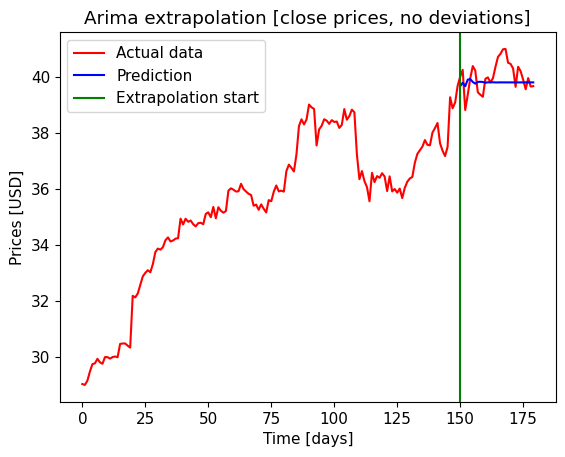

RMS: 0.56 


In [13]:
%%capture --no-stdout --no-display
arima.present_prediction()

In [14]:
%%capture --no-stdout --no-display
arima.compute_statistics_set()

Statistics [Apple stock, close price, 3 iterations]

  Deviations source Deviations scale Avg time [ms] Std dev time Avg RMS  \
0              none             none   7222.333333   100.748863    0.56   
1             noise         slightly          3615    229.79121   0.785   
2             noise       moderately   3852.333333    30.989245   1.635   
3             noise           highly   6866.666667    19.553346   3.527   
4    incompleteness         slightly   6632.333333    57.761002   4.398   
5    incompleteness       moderately   6000.333333   638.822615  16.769   
6    incompleteness           highly   4304.666667   107.192972  18.417   

  Std dev RMS  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
\begin{tabular}{llllll}
\toprule
Deviations source & Deviations scale & Avg time [ms] & Std dev time & Avg RMS & Std dev RMS \\
\midrule
             none &             none &        7222.3 &        100.7 &     0.6 &  

## Reservoir computing

In [15]:
from predictions.ml import Reservoir

reservoir = model.configure_model(Reservoir)

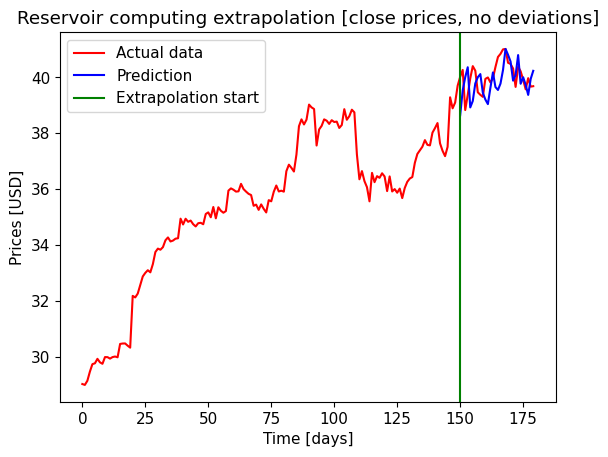

RMS: 0.778 


In [16]:
reservoir.present_prediction()

In [17]:
%%capture --no-stdout --no-display
reservoir.compute_statistics_set()

Statistics [Apple stock, close price, 3 iterations]

  Deviations source Deviations scale Avg time [ms] Std dev time    Avg RMS  \
0              none             none            16          1.0   0.807667   
1             noise         slightly            16          0.0      0.995   
2             noise       moderately            16          0.0   1.634667   
3             noise           highly     17.333333     2.309401   3.593667   
4    incompleteness         slightly     14.666667     2.309401      2.262   
5    incompleteness       moderately            16         10.0     17.781   
6    incompleteness           highly            16          0.0  21.150667   

  Std dev RMS  
0    0.119876  
1    0.019925  
2    0.097838  
3    0.089579  
4    0.314759  
5    0.423501  
6    0.767486  
\begin{tabular}{llllll}
\toprule
Deviations source & Deviations scale & Avg time [ms] & Std dev time & Avg RMS & Std dev RMS \\
\midrule
             none &             none &            16 &   

## XGBoost

In [18]:
from ml import XGBoost

xgboost = model.configure_model(XGBoost, optimize=False)

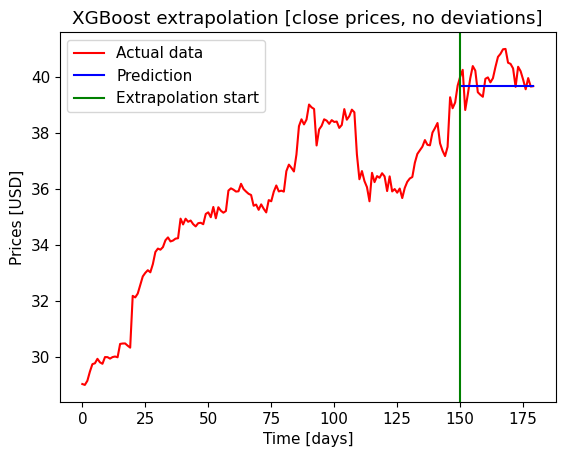

RMS: 0.616 


In [19]:
xgboost.present_prediction()

In [20]:
%%capture --no-stdout --no-display
xgboost.compute_statistics_set()

Statistics [Apple stock, close price, 3 iterations]

  Deviations source Deviations scale Avg time [ms] Std dev time Avg RMS  \
0              none             none     48.666667     5.686241   0.616   
1             noise         slightly     52.666667     8.962886   0.922   
2             noise       moderately            55     7.549834   1.545   
3             noise           highly            44     5.196152   3.204   
4    incompleteness         slightly            63    41.388404   0.616   
5    incompleteness       moderately            47          0.0  35.784   
6    incompleteness           highly            59     5.196152  35.014   

  Std dev RMS  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
\begin{tabular}{llllll}
\toprule
Deviations source & Deviations scale & Avg time [ms] & Std dev time & Avg RMS & Std dev RMS \\
\midrule
             none &             none &          48.7 &          5.7 &     0.6 &  